In [4]:
# preparing data

cancer = pd.read_csv("C:/Users/DELL/Downloads/Cancer_Data.csv")
cancer1 = cancer.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(cancer1)) #scaling the data
pca = PCA(n_components = 6)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3','PC4','PC5','PC6'])
data_pca['output'] = cancer['diagnosis']
data_pca.output[data_pca.output == 'M'] = 1
data_pca.output[data_pca.output == 'B'] = 0
scaler = MinMaxScaler()
cancer_data = scaler.fit_transform(data_pca)
X = cancer_data[:, 0:6]
Y = cancer_data[:,6]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

C:\Users\DELL\AppData\Local\Temp\ipykernel_6888\785812838.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pca.output[data_pca.output == 'M'] = 1
C:\Users\DELL\AppData\Local\Temp\ipykernel_6888\785812838.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pca.output[data_pca.output == 'B'] = 0


The code we're about to make would perform parameterized operations on a vector of some input information (just like a NN). So the first part should be to formulate a way to store that information in some container. The given dataset has 6 features (We've reduced it to 6 features to make the demonstration easy). We need one subcontainer to represent each feature. Classicaly, each container would have multiple bits to represent the input number. Each classical bit has a state $|\psi\rangle$ that can be represented as:
$$ |\psi\rangle = p|0\rangle + (1-p)|1\rangle $$
Here, if p = 0, then the state of the bit is, $$ |\psi\rangle = |1\rangle $$ Generally, we call it the 'on' state. Else, if p = 1, then the state of the bit is, $$ |\psi\rangle = |0\rangle $$ It is called the 'off' state. The sum of coefficients in the above equation is 1.
For a subcontainer to represent a decimal number using the binary system, we generally use multiple bits. We claim that we can do it using a newly defined bit. $$ |\psi\rangle = cos\frac{\theta}{2}|0\rangle + sin\frac{\theta}{2}|1\rangle $$
We call it a qubit. By the nature of sine and cosine functions, it is capable of representing any number between 0 and 1 and capable of being in a combination of fractional $|0\rangle$ and $|1\rangle$ states, a combination of partial on and off states. So, putting just a single qubit in a subcontainer should do the job. 6 such subcontainers should do the job for us. For a subcontainer, which we will now call a qubit, to represent a number, we shall first notice that the sum of squares the coefficient is 1. If we want a qubit to represent a number, say $\frac{3}{4}$, then our qubit sould be in a '$\frac{3}{4}$'-'on' state. Hence, it should be in '$\frac{1}{4}$'-'off' state. Since $ sin^2\frac{\theta}{2} + cos^2\frac{\theta}{2} = 1 $, we require the sine component to take up the responsibility to represent the 'on' state. That is, $ sin^2\frac{\theta}{2} = \frac{3}{4} $ and $ cos^2\frac{\theta}{2} = \frac{1}{4} $. It is clear that the state $ |\psi\rangle $ is a $ \theta $ dependent state, so quite naturally we can say that $ \theta = 2sin^{-1}\frac{\sqrt{3}}{2} $. 

We hereby conclude that whatever value, say p, has to be represented by the qubit, can be mapped to an angle theta by the following relation. $$ \theta = 2sin^{-1}(\sqrt{p}) $$ So lets start with defining a function to map the desired input to an angle which can represent the state of a qubit.

In [5]:
# importing the required functions
from math import asin, sqrt

def val_to_angle(input_val):
    
    return 2*asin(sqrt(input_val))

# to demonstrate it, lets run it for an input value of 3/4 ~ 0.75.
val_to_angle(3/4)

2.0943951023931953

The result is obtained in radians. Now let's represent a qubit, as a part of a Quantum Circuit.

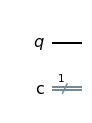

In [9]:
from qiskit import QuantumCircuit

# Fixing the number of qubits and the number of bits we want. Classical bits are used to store the information retrieved from the measurement of the Quantum Circuit.
num_qubits = 1
num_cls_bits = 1
# Making a container.
qc = QuantumCircuit(num_qubits, num_cls_bits)

# Visualizing it.
qc.draw('mpl')

Above, we have an empty container named q. No action has been performed on it yet. Lets use our val_to_angle function to manipulate its state to represent a value 3/4. For that, we need to rotate it from its initial state. Remember, the way we defined qubit suggests that for an angle $ \theta = 0 $, it will be in the state $ |0\rangle $, i.e., the 'off' state. We must rotate it towards the 'on' state. We use a rotation gate called the Pauli Rotation gate.

Applying rotation gate upon the state of nth qubit in the circuit to rotate it by an angle theta such that it is in '3/4' on state:

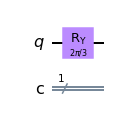

In [10]:
theta = val_to_angle(3/4)
qc.ry(theta, 0)
qc.draw('mpl')

Now we have a tiny quantum circuit and we need a way to simulate it.In Qiskit, Aer is a high-performance simulator framework for quantum circuits. It provides various backends that allow you to simulate the behavior of quantum circuits on classical computers. Aer offers different types of simulators, including statevector simulators, unitary simulators, and noisy simulators. The execute function is used to run quantum circuits on either a simulator or a real quantum device.

{'1': 75130, '0': 24870}


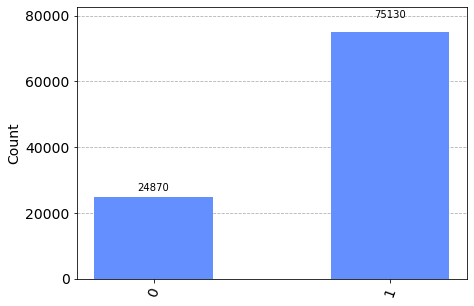

In [24]:
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram

# measuring 0th  qubit and storing its state in 0th classical bit
qc.measure(0,0)

# getting a backend from Aer to simulate the quantum circuit
backend = Aer.get_backend('qasm_simulator')

# executing the qc with backend
# we choose shots = 1000, quantum mechanics is probabilistic, one shot corresponds to one measurement of the circuit
# we measure it multiple times to get an idea of where it saturates
results = execute(qc, backend, shots = 100000).result()

# we get the count of results, i.e., the count of the number of times the circuit was measured as 0 or 1 
counts = results.get_counts()

print(counts)

plot_histogram(counts)

The counts we obtained are in correspondence with the encoding scheme. The probability of getting 1 is:

In [14]:
prob_1 = counts['1']/(counts['0'] + counts['1'])

prob_1

0.75074

This is almost equal to the value the qubit was encoded with, i.e., $\frac{3}{4}$. Now, lets encode an array of qubits to represent all the 6 features of a dataset.

In [49]:
num_qubits= 6

# create quantum circuit
qc1 = QuantumCircuit(num_qubits)

print("The first data instance: \n{}\n\n".format(X_train[0]))

# encoding the feature values
theta_val = list(map(lambda item: val_to_angle(item), X_train[0]))

print("The first data instance after being transformed to be fed to the qubits: \n{}".format(theta_val))

The first data instance: 
[0.11495611 0.27215369 0.29420206 0.51477828 0.51835959 0.49471461]


The first data instance after being transformed to be fed to the qubits: 
[0.6918175926715661, 1.0976461675913045, 1.1465918651851292, 1.6003571875245484, 1.6075237562615812, 1.5602253510857418]


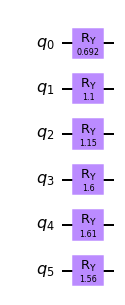

In [50]:
# using these values as angles to encode the qubit state
for qubit_number in range(6):
    
    # rotation each qubit using Ry gate by an angle 
    qc1.ry(theta_val[qubit_number], qubit_number)
    
# visualizing 
qc1.draw('mpl')

Now we have a state, which can be transformed however we desire by applying appropriate operations. This resembles the input layer of a neural network. Upon this, we need to apply a structure similar to parameterized hidden layers in Neural Networks. In quantum circuit, we call such a circuit the Parameterized Quantum Circuit or the Ansatz. An ansatz consists of multiple layer and each layer has two parts. The first part consists of a parameterized rotation gates being applied to each qubit. The rotation gates are no longer limited to Ry gates. We shall use Rx and Rz as well. The second layer entangles all the qubits together. The entangling gates are not one qubit operation. They are multi-qubit operations in which the state of one or more qubits control the state of the target qubit. First lets apply the first part of Ansatz.

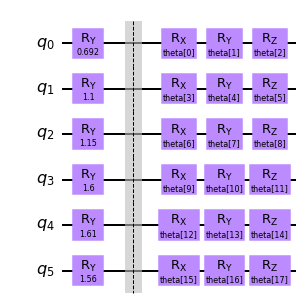

In [51]:
# first we define a parameter vector
from qiskit.circuit import ParameterVector

# for 6 qubits, we need 6 times 3 parameters to parameterize the rotation gates
num_parameters = 6*3
theta_vector = ParameterVector('theta', num_parameters)

index = 0

qc1.barrier()

for num_qubit in range(6):
    
    qc1.rx(theta_vector[index], num_qubit)
    qc1.ry(theta_vector[index+1], num_qubit)
    qc1.rz(theta_vector[index+2], num_qubit)
    
    index = index+3
    
qc1.draw('mpl')

Now we have a input state being acted upon by rotation gates but there are no relations between any 2 qubits. Yet. Now we shall apply the second part of a layer of Ansatz. The entangling layer. We use 2 qubit CX (controlled not) gates to entangle 2 qubits. Firstly, a not gate (X gate) is the one which flips the state of a qubit. For example, $$ X|0\rangle = |1\rangle $$ So, a controlled not gate (CX gate) transforms in the following way. 

$$ CX|\alpha\rangle \otimes |\psi\rangle = |\alpha\rangle \otimes X^{\alpha}|\psi\rangle $$ 

Here, $ \alpha $ is the control qubit and $ \psi $ is the target qubit. For $ |\alpha\rangle = a|0\rangle + b|1\rangle $ and $ |\psi\rangle = c|0\rangle + d|1\rangle $ 

$$ CX|\alpha\rangle \otimes |\psi\rangle = (a|0\rangle + b|1\rangle) \otimes X^{\alpha}(c|0\rangle + d|1\rangle) $$

$$ CX|\alpha\rangle \otimes |\psi\rangle = ac|0\rangle X^0 |0\rangle + ad|0\rangle X^0 |1\rangle + bc|1\rangle X^1 |0\rangle + bd |1\rangle X^1 |1\rangle$$ 

$$ CX|\alpha\rangle \otimes |\psi\rangle = ac|0\rangle|0\rangle + ad|0\rangle|1\rangle + bc|1\rangle|1\rangle + bd |1\rangle|0\rangle$$ 

Adding and subtract $ bc|1\rangle|0\rangle $ and $ bd |1\rangle|1\rangle $

$$ CX|\alpha\rangle \otimes |\psi\rangle = ac|0\rangle|0\rangle + ad|0\rangle|1\rangle + bc|1\rangle|0\rangle - bc|1\rangle|0\rangle + bc|1\rangle|1\rangle + bd |1\rangle|0\rangle + bd |1\rangle|1\rangle - bd |1\rangle|1\rangle$$

Rearranging,

$$ CX|\alpha\rangle \otimes |\psi\rangle = ac|0\rangle|0\rangle + ad|0\rangle|1\rangle + bc|1\rangle|0\rangle + bd |1\rangle|1\rangle - bc|1\rangle|0\rangle + bc|1\rangle|1\rangle + bd |1\rangle|0\rangle - bd |1\rangle|1\rangle$$ 

$$ CX|\alpha\rangle \otimes |\psi\rangle = (a|0\rangle + b|1\rangle) \otimes (c|0\rangle + d|1\rangle) - bc|1\rangle|0\rangle + bc|1\rangle|1\rangle + bd |1\rangle|0\rangle - bd |1\rangle|1\rangle$$ 

$$ CX|\alpha\rangle \otimes |\psi\rangle = |\alpha\rangle \otimes |\psi\rangle - bc|1\rangle|0\rangle + bc|1\rangle|1\rangle + bd |1\rangle|0\rangle - bd |1\rangle|1\rangle$$ 

This is a depiction of correlations that are developed by entangling the qubits. Now lets apply two qubit CX gates to entangle each qubit.

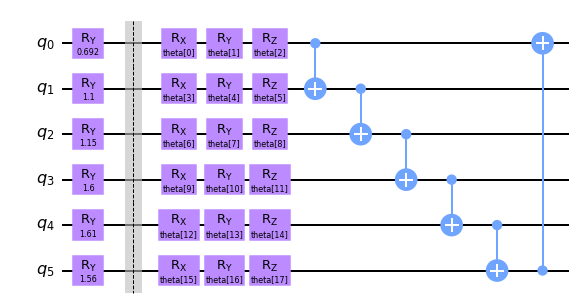

In [52]:
for num_qubit in range(6-1):
    # entangling the consecutive qubits
    qc1.cx(num_qubit, num_qubit+1)

# entangling the first and the last qubit
qc1.cx(5, 0)

qc.barrier()

qc1.draw('mpl')

Now we have a Quantum Circuit with qubits encoded using input data and an Ansatz with 1 layer consisiting of rotation and entangling layer. We have a library in qiskit which can provide us an ansatz with various rotation and entangling schemes. We can append that Ansatz circuit to the encoded data structure.

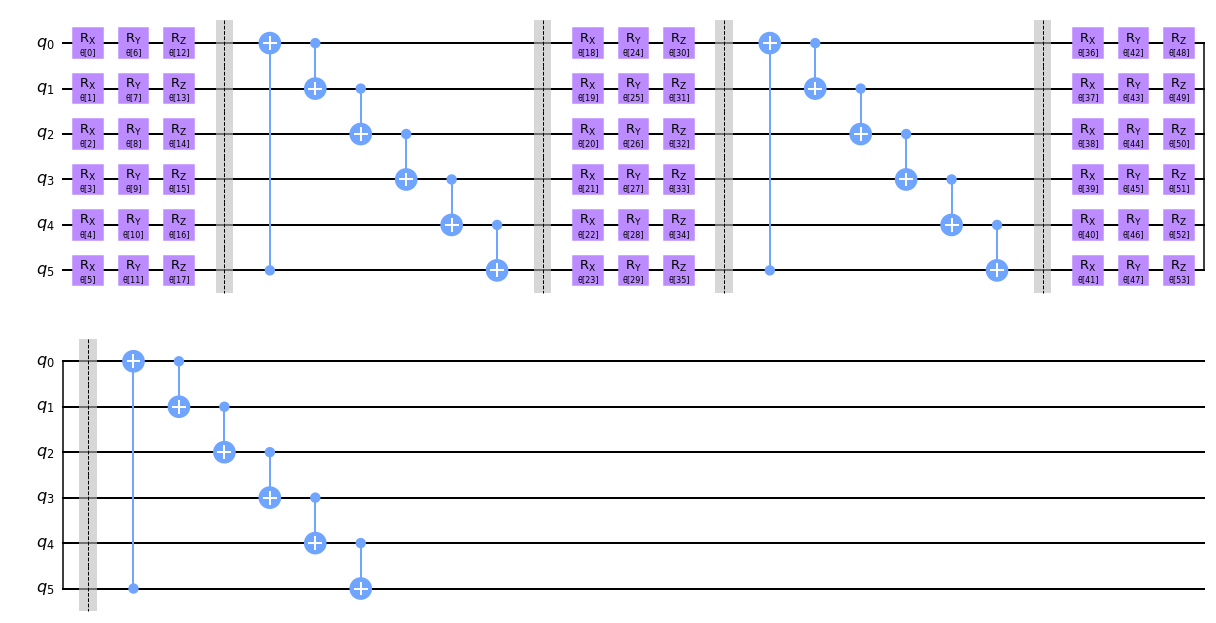

In [69]:
# importing PQC
from qiskit.circuit.library import TwoLocal


rotation_gates = ['rx', 'ry', 'rz']
entangling_gates = 'cx'
entangling_scheme = 'circular'
num_layers = 3

Ansatz = TwoLocal(6, rotation_gates, entangling_gates, entangling_scheme, reps = num_layers, skip_final_rotation_layer = True, insert_barriers = True)
Ansatz.name = 'Ansatz'

# visualizing
Ansatz.decompose().draw('mpl')

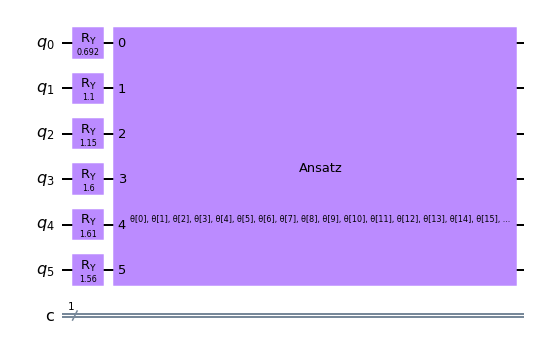

In [77]:
# make a new quantum circuit for data
qc2 = QuantumCircuit(6,1)

for qubit_number in range(6):
    
    # rotation each qubit using Ry gate by an angle 
    qc2.ry(theta_val[qubit_number], qubit_number)
    
# defining the string of qubit indices to which the Ansatz has to be appended
string_indices = [i for i in range(6)]

qc.barrier()

# appending the above ansatz to the Quantum Circuit
qc2.append(Ansatz, string_indices)

# visualizing
qc2.draw('mpl')

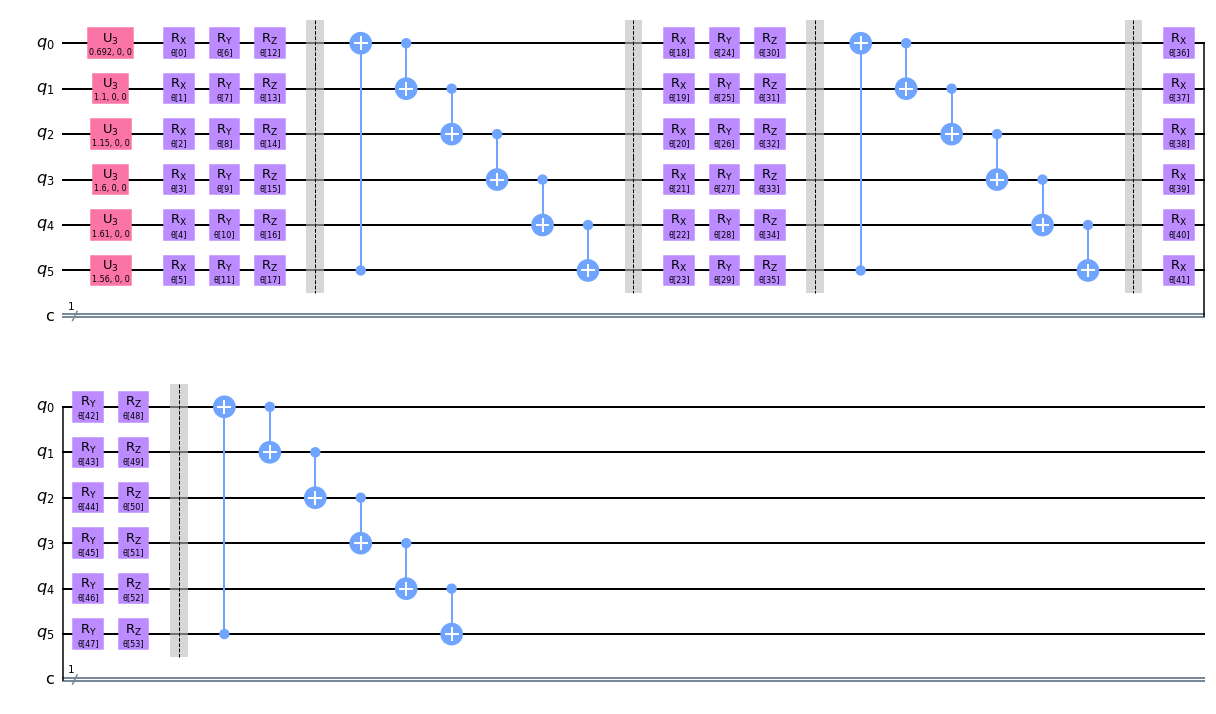

In [78]:
# detailed view of Ansatz
qc2.decompose().decompose().draw('mpl')

Now we have encode the data in the qubits and then applied a parameterized circuit. The state at the end is a function of parameters. It resembles a Neural Network with input layer and hidden layers. The last step is measuring the state of a qubit. Our task is binary classification. We measure only one qubit for two reasons. First, more the number of qubits are measured, more is the error in measurement on a real quantum device. Second, measuring more number of qubits pushes us in a Barren Plateau. So we avoid measuring multiple qubits. But first, we need to bind the real values with the Quantum Circuit in place of parameters. The parameters are:

In [79]:
qc2.parameters

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15]), ParameterVectorElement(θ[16]), ParameterVectorElement(θ[17]), ParameterVectorElement(θ[18]), ParameterVectorElement(θ[19]), ParameterVectorElement(θ[20]), ParameterVectorElement(θ[21]), ParameterVectorElement(θ[22]), ParameterVectorElement(θ[23]), ParameterVectorElement(θ[24]), ParameterVectorElement(θ[25]), ParameterVectorElement(θ[26]), ParameterVectorElement(θ[27]), ParameterVectorElement(θ[28]), ParameterVectorElement(θ[29]), ParameterVectorElement(θ[30]), ParameterVectorElement(θ[31]), Par

So, there are 54 parameters, lets bind them.

In [80]:
import numpy as np

# defining random parameters
parameters = np.random.rand(54)

# making a dictionary with a parameter as key and a numeric value as the value to be bound
parameters_dictionary = dict(zip(qc2.parameters, parameters))

# binding these parameters with quantum circuit
qc2 = qc2.bind_parameters(parameters_dictionary)

# after binding, the circuit should have no parameters
qc2.parameters

ParameterView([])

Now we are ready to measure the state of a qubit, say qubit 0. We shall again use the 'qasm_simulator' as backend to simulate the circuit.

In [83]:
# measuring the 0th qubit and storing the state in 0th classical bit
qc2.measure(0,0)

# defining backend
backend = Aer.get_backend('qasm_simulator')

# executing the circuit
results = execute(qc2, backend, shots = 1000).result()

# measuring the counts of 0 and 1
counts = results.get_counts()

print(counts)

{'1': 437, '0': 563}


So the probabilities of class 0 and class 1 are given as:

In [84]:
print(f"The probabilities of class 0 is {counts['0']/(counts['0'] + counts['1'])}.\nThe probability of class 1 is {counts['1']/(counts['0'] + counts['1'])}.")

The probabilities of class 0 is 0.563.
The probability of class 1 is 0.437.


Now we can construct a neural network.

In [98]:
import time 
# defining a function to encode data
def encoder(input_size, circuit, sample, dataset):
    
    # extracting the data instance at the index 'sample'
    val = dataset[sample][0:6]
    
    # turning the feature values to angle (angle encoding)
    val = list(map(lambda item: val_to_angle(item), val))
    
    # defining a circuit to encode data
    encoder_circuit = QuantumCircuit(input_size)
    
    # encoding the state of each qubit
    for i in range(input_size):
        encoder_circuit.ry(val[i], i)
    
    # appending encoder circuit to mother circuit
    circuit.append(encoder_circuit, [k for k in range(input_size)])
    
    return circuit

In [109]:
# defining a function to construct an Ansatz
def ansatz(input_size, circuit, layers, params):
    
    # defining an ansatz
    qnn = TwoLocal(input_size, ['rx', 'ry', 'rz'], 'cx', 'circular', reps = layers, skip_final_rotation_layer = True, insert_barriers = True)
    
    # appending ansatz to mother circuit
    circuit.append(qnn, [k for k in range(input_size)])
    
    # add bias
    # defining a parameter vector
    theta1 = ParameterVector('theta1', input_size)
    
    for qubit in range(input_size):
        
        # adding parameterized Ry rotation to each qubit 
        circuit.ry(theta1[qubit], qubit)
    
    return circuit

In [112]:
# defining a function to predict the state
def predict(params):
    
    # an empty list to store predictions
    predictions = []
    
    # noting the runtime of circuit
    start = time.time()
    
    for sample in range(len(X_train)):
        
        # constructing quantum circuit
        qc = QuantumCircuit(6,1)
        encoder(6, qc, sample, X_train)
        ansatz(6, qc, 4, params)
        
        qc = qc.bind_parameters(dict(zip(qc.parameters, params)))
    
        # measuring the first qubit
        qc.measure(0,0)

        # executing the circuit
        results = execute(qc, Aer.get_backend('qasm_simulator'), shots = 1000).result().get_counts()
        
        # predicting
        pred = results['1']/1000
        
        # appending prediction
        predictions.append(pred)    
            
    end = time.time()
    duration = end-start
    print(f"The runtime of the circuit is {duration}.\n\n")
    
    return predictions, Y_train

In [113]:
# predicting using random parameters
predictions, labels = predict(np.random.rand(78))

The runtime of the circuit is 79.63019752502441.




In [114]:
# We have successfully predicted using Quantum Neural Network.
print("The predictions and labels are:\n")
list(zip(predictions, labels))

The predictions and labels are:



[(0.482, 0.0),
 (0.481, 0.0),
 (0.503, 0.0),
 (0.491, 0.0),
 (0.497, 0.0),
 (0.486, 1.0),
 (0.492, 0.0),
 (0.506, 0.0),
 (0.499, 0.0),
 (0.533, 0.0),
 (0.51, 0.0),
 (0.543, 0.0),
 (0.488, 1.0),
 (0.462, 1.0),
 (0.509, 1.0),
 (0.502, 0.0),
 (0.506, 0.0),
 (0.536, 1.0),
 (0.499, 0.0),
 (0.477, 1.0),
 (0.514, 0.0),
 (0.479, 0.0),
 (0.49, 0.0),
 (0.491, 0.0),
 (0.492, 1.0),
 (0.492, 0.0),
 (0.527, 0.0),
 (0.491, 1.0),
 (0.525, 0.0),
 (0.492, 0.0),
 (0.525, 0.0),
 (0.424, 1.0),
 (0.504, 0.0),
 (0.472, 1.0),
 (0.473, 1.0),
 (0.499, 0.0),
 (0.516, 0.0),
 (0.515, 0.0),
 (0.524, 1.0),
 (0.546, 0.0),
 (0.477, 0.0),
 (0.542, 0.0),
 (0.483, 0.0),
 (0.563, 1.0),
 (0.517, 0.0),
 (0.51, 0.0),
 (0.471, 0.0),
 (0.505, 0.0),
 (0.486, 0.0),
 (0.53, 1.0),
 (0.518, 0.0),
 (0.485, 1.0),
 (0.541, 1.0),
 (0.507, 0.0),
 (0.496, 0.0),
 (0.429, 1.0),
 (0.511, 0.0),
 (0.51, 0.0),
 (0.515, 0.0),
 (0.522, 0.0),
 (0.496, 0.0),
 (0.407, 0.0),
 (0.542, 0.0),
 (0.506, 1.0),
 (0.483, 1.0),
 (0.451, 1.0),
 (0.53, 0.0),
 

Now we are left with optimizing the parameters to get the optimized predictions. That will be discussed in further discussions.